Using device: cuda


/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal


=== SUMMARY ===
 ImageSize Partition Epsilon FinalAcc Comm(Mb) FinalEps MIA_AUC MIA_Acc MemberLoss NonMemberLoss MembersConf NonMembersConf ModelInvProxy% DataReconProxy% PropInfProxy GradPoisonRes% CollusionRes%
        28       iid    NoDP    0.967   654.76      N/A   0.505   0.513      0.120         0.145       0.957          0.956           0.08           17.25          N/A          21.76         90.00
        28       iid     1.0    0.964   654.76 4853.395   0.501   0.507      0.134         0.126       0.960          0.960           0.00            0.00          N/A          22.65         90.00
        28       iid     0.5    0.955   654.76 4853.395   0.513   0.517      0.181         0.174       0.951          0.945           0.51            0.00          N/A          21.92         90.00
        28   non-iid    NoDP    0.919   645.48      N/A   0.503   0.508      0.215         0.195       0.929          0.934           0.00            0.00          N/A          22.88         90.0

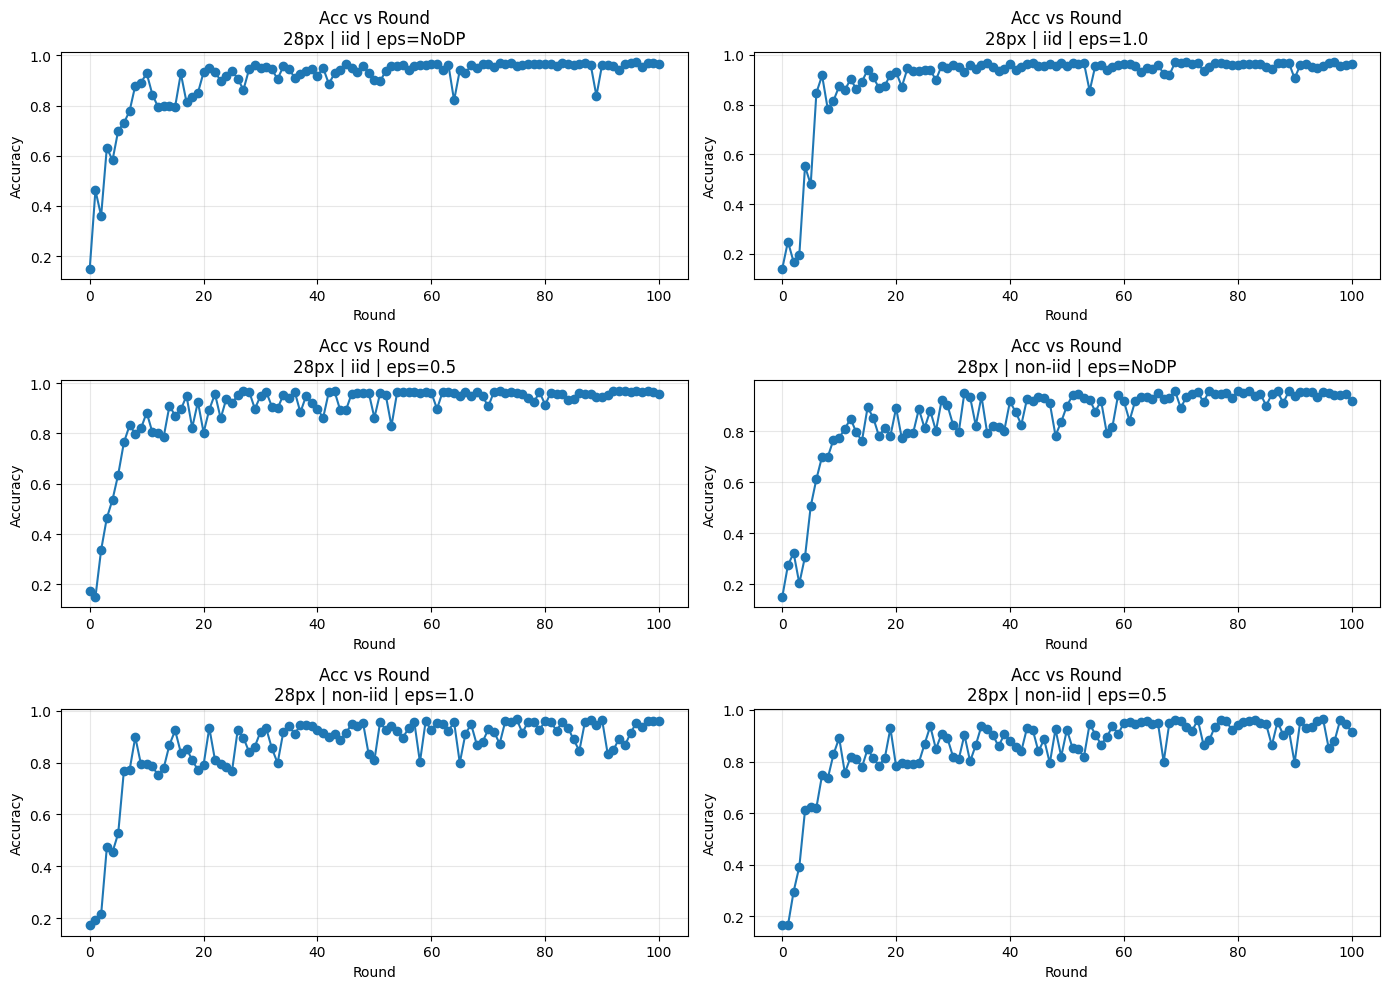

In [ ]:
# ancco_fl_with_entropy_opacus.py
"""
ANCCO-FL - Extended
- Adds entropy-based quantization (EntropyQuantizer)
- Adds optional server-side noise (sigma_server) in PNCA
- Uses Opacus RDP accountant when available; falls back to MomentsAccountant otherwise
- Keeps previous experimental logic (IID/non-IID, communication tracking, MIA proxy)
"""

import os
import math
import random
import logging
import hashlib
from typing import Dict, List, Tuple, Optional
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from torchvision import datasets, transforms
import torch.nn.functional as F

# Try Opacus RDP accountant
try:
    from opacus.accountants import RDPAccountant
    OPACUS_AVAILABLE = True
except Exception:
    OPACUS_AVAILABLE = False

# --------------------------
# Configuration / Seeding
# --------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {dev}")

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("ANCCO-FL-EXPTS")

# ==========================
# Privacy Accountants
# ==========================
class MomentsAccountant:
    """Simplified Moments-like accountant (fallback)."""
    def __init__(self, delta: float = 1e-5):
        self.delta = delta
        self.epsilon = 0.0

    def step(self, sigma: float, sample_rate: float, steps: int = 1):
        for _ in range(steps):
            eps_step = math.sqrt(2 * math.log(1.25 / max(self.delta, 1e-12))) / max(sigma, 1e-12)
            eps_step *= sample_rate
            self.epsilon += eps_step

    def get_epsilon(self):
        return float(self.epsilon)

class OpacusAccountantWrapper:
    """Wrapper around Opacus RDPAccountant for simple step/get_epsilon interface."""
    def __init__(self, noise_multiplier: float, sample_rate: float, delta: float = 1e-5):
        if not OPACUS_AVAILABLE:
            raise RuntimeError("Opacus not available. pip install opacus to enable RDP accounting.")
        self.accountant = RDPAccountant()
        self.noise_multiplier = float(noise_multiplier)
        self.sample_rate = float(sample_rate)
        self.delta = float(delta)
        # no pre-initial steps; step() will increment

    def step(self):
        # Opacus expects noise_multiplier and sample_rate per step
        self.accountant.step(noise_multiplier=self.noise_multiplier, sample_rate=self.sample_rate)

    def get_epsilon(self):
        try:
            eps = self.accountant.get_epsilon(self.delta)
            return float(eps)
        except Exception:
            return None

# ==========================
# Secure Seed Management
# ==========================
class SecureSeedManager:
    def __init__(self, initial_seed: int = SEED):
        self.base_seed = int(initial_seed) & 0xFFFFFFFF
        self.seed_history: Dict[int, int] = {}

    def get_round_seed(self, round_idx: int, client_id: Optional[int] = None) -> int:
        if round_idx not in self.seed_history:
            seed_data = f"{self.base_seed}_{round_idx}".encode()
            round_seed = int(hashlib.sha256(seed_data).hexdigest()[:8], 16) % (2**32)
            self.seed_history[round_idx] = int(round_seed)
        if client_id is not None:
            client_seed_data = f"{self.seed_history[round_idx]}_{client_id}".encode()
            return int(hashlib.sha256(client_seed_data).hexdigest()[:8], 16) % (2**32)
        return self.seed_history[round_idx]

# ==========================
# Entropy-based Quantizer
# ==========================
class EntropyQuantizer:
    """
    Entropy-based adaptive quantizer:
      - estimates Shannon entropy per tensor,
      - uses a combination of global norm and average entropy to pick bits
    """
    def __init__(self, min_bits: int = 4, max_bits: int = 16, sigma_quant: float = 0.5, default_bins: int = 100):
        self.min_bits = int(min_bits)
        self.max_bits = int(max_bits)
        self.sigma_quant = float(sigma_quant)
        self.default_bins = int(default_bins)

    def shannon_entropy(self, tensor: torch.Tensor, num_bins: int = None) -> float:
        num_bins = num_bins or self.default_bins
        arr = tensor.detach().cpu().numpy().flatten()
        if arr.size < 2:
            return 0.0
        hist, _ = np.histogram(arr, bins=num_bins, density=False)
        p = hist.astype(np.float64) / max(1, hist.sum())
        p = p[p > 0]
        if p.size == 0:
            return 0.0
        return float(-np.sum(p * np.log2(p)))

    def bits_for(self, param_dict: Dict[str, torch.Tensor], data_size: int = 1000) -> int:
        """Compute a single bits allocation for whole delta dict (as in paper approach)."""
        # flatten and compute norm
        if len(param_dict) == 0:
            return self.min_bits
        flat = torch.cat([p.view(-1) for p in param_dict.values()])
        grad_norm = float(torch.norm(flat).item())
        if grad_norm < 1e-12:
            return self.min_bits

        # base bits from norm
        base_bits = max(self.min_bits, math.ceil(math.log2(1 + grad_norm / self.sigma_quant)))

        # average entropy across parameters
        total_entropy = 0.0
        count = 0
        for t in param_dict.values():
            ent = self.shannon_entropy(t)
            total_entropy += ent
            count += 1
        avg_entropy = (total_entropy / max(1, count))

        # map entropy to factor: assume typical entropy around 4..12 for many small tensors
        entropy_factor = 1.0 + (avg_entropy - 4.0) / 10.0
        entropy_factor = float(max(0.6, min(1.6, entropy_factor)))

        # data_size factor (small clients -> fewer bits)
        data_factor = float(min(1.4, math.log(1 + data_size / 1000.0) + 1.0))

        final_bits = int(max(self.min_bits, min(self.max_bits, round(base_bits * entropy_factor * data_factor))))
        return final_bits

    def quantize_tensor(self, t: torch.Tensor, bits: int) -> torch.Tensor:
        orig_device = t.device
        orig_dtype = t.dtype
        t_cpu = t.detach().cpu()
        if bits >= 16:
            return t_cpu.to(device=orig_device, dtype=orig_dtype)
        t_min = float(t_cpu.min().item())
        t_max = float(t_cpu.max().item())
        rng = t_max - t_min
        if rng < 1e-12:
            return t_cpu.to(device=orig_device, dtype=orig_dtype)
        levels = 2 ** bits
        scale = (levels - 1) / rng
        q = torch.round((t_cpu - t_min) * scale)
        dq = q / scale + t_min
        return dq.to(device=orig_device, dtype=orig_dtype)

    def quantize_dict(self, param_dict: Dict[str, torch.Tensor], bits: int) -> Dict[str, torch.Tensor]:
        return {k: self.quantize_tensor(v, bits) for k, v in param_dict.items()}

# ==========================
# Synthetic Dataset (Fallback)
# ==========================
class SyntheticMedicalDataset(Dataset):
    def __init__(self, num_samples=10000, img_size=28, num_classes=6):
        self.num_samples = int(num_samples)
        self.img_size = int(img_size)
        self.num_classes = int(num_classes)
        self.data = torch.randn(self.num_samples, 1, self.img_size, self.img_size)
        self.targets = torch.randint(0, self.num_classes, (self.num_samples,), dtype=torch.long)
    def __len__(self):
        return self.num_samples
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# ==========================
# Dataset Loading (Medical MNIST)
# ==========================
def try_load_medical_mnist(root_candidates: List[str], img_size: int):
    for root in root_candidates:
        train_dir = os.path.join(root, "train")
        if os.path.exists(train_dir):
            transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
            ])
            full_train = datasets.ImageFolder(train_dir, transform=transform)
            num_classes = len(full_train.classes)
            logger.info(f"Loaded Medical MNIST from {root} with {num_classes} classes at {img_size}x{img_size}.")
            train_size = int(0.8 * len(full_train))
            val_size = len(full_train) - train_size
            train_ds, test_ds = random_split(full_train, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))
            return train_ds, test_ds, num_classes
    return None, None, None

def load_or_create_dataset(img_size: int = 28):
    candidates = [
        "/kaggle/input/medical-mnist-train-test-val",
        "./data/medical_mnist",
        "/data/medical_mnist",
    ]
    train_ds, test_ds, num_classes = try_load_medical_mnist(candidates, img_size)
    if train_ds is None:
        logger.warning("Medical MNIST not found. Falling back to synthetic dataset.")
        train_ds = SyntheticMedicalDataset(num_samples=8000, img_size=img_size)
        test_ds = SyntheticMedicalDataset(num_samples=2000, img_size=img_size)
        num_classes = 6
    return train_ds, test_ds, num_classes

# ==========================
# Model
# ==========================
class SimpleNet(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, num_classes=6):
        super().__init__()
        self.fc1 = nn.Linear(int(input_dim), int(hidden_dim))
        self.fc2 = nn.Linear(int(hidden_dim), 64)
        self.fc3 = nn.Linear(64, int(num_classes))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    def forward(self, x):
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# ==========================
# ANCCO-FL Client / Server (with server-side noise & entropy quantizer)
# ==========================
class ANCCOFLClient:
    def __init__(self, client_id, data_loader, epsilon=1.0, clip_norm=1.0, sigma_noise=0.1,
                 seed_manager=None, quantizer=None, input_dim=784, num_classes=6):
        self.client_id = int(client_id)
        self.data_loader = data_loader
        self.epsilon = epsilon
        self.clip_norm = float(clip_norm)
        self.sigma_noise = float(sigma_noise)
        self.seed_manager = seed_manager or SecureSeedManager()
        self.quantizer = quantizer or EntropyQuantizer()
        self.model = SimpleNet(input_dim=input_dim, num_classes=num_classes).to(dev)
        self.optimizer = optim.SGD(self.model.parameters(), lr=0.01)
        self.criterion = nn.CrossEntropyLoss()
        self.historical_norm = float(self.clip_norm)

    def adaptive_clip(self, gradients, norm_factor=0.9):
        if not gradients:
            return float(self.historical_norm)
        current_norm = float(torch.norm(torch.cat([g.view(-1) for g in gradients if g is not None])).item())
        self.historical_norm = norm_factor * self.historical_norm + (1 - norm_factor) * current_norm
        return float(max(0.1, min(2.0, self.historical_norm)))

    def generate_noise(self, shape, round_idx, is_common=True, sigma=None):
        sigma = float(self.sigma_noise if sigma is None else sigma)
        if is_common:
            seed = self.seed_manager.get_round_seed(round_idx)
        else:
            seed = self.seed_manager.get_round_seed(round_idx, self.client_id)
        gen = torch.Generator(device=dev).manual_seed(int(seed) & 0xFFFFFFFF)
        return torch.randn(size=shape, generator=gen, device=dev) * sigma

    def local_train(self, global_state, round_idx, epochs=1):
        # load global weights
        self.model.load_state_dict(global_state)
        self.model.train()
        clip = float(self.clip_norm)
        for _ in range(epochs):
            for data, target in self.data_loader:
                data = data.to(dev)
                if not isinstance(target, torch.Tensor):
                    target = torch.tensor(target, dtype=torch.long, device=dev)
                else:
                    target = target.to(dev)
                self.optimizer.zero_grad()
                out = self.model(data)
                loss = self.criterion(out, target)
                loss.backward()
                grads = [p.grad.detach().clone() for p in self.model.parameters() if p.grad is not None]
                clip = self.adaptive_clip(grads)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), clip)
                self.optimizer.step()

        update = {}
        for name, param in self.model.named_parameters():
            gs = global_state[name].to(dev)
            update[name] = (param.data - gs).detach().clone()

        # entropy-based bits selection for whole update
        bits = self.quantizer.bits_for(update, data_size=len(self.data_loader.dataset) if hasattr(self.data_loader, 'dataset') else 1000)
        quantized_update = self.quantizer.quantize_dict(update, bits)

        # add deterministic common + individual noise
        noisy_update = {}
        for name, tensor in quantized_update.items():
            common = self.generate_noise(tensor.shape, round_idx, is_common=True)
            indiv = self.generate_noise(tensor.shape, round_idx, is_common=False)
            noisy_update[name] = (tensor + common + indiv).detach().clone()

        # comm cost in bits (approx): num_elements * bits
        comm_bits = sum(t.numel() * bits for t in quantized_update.values())

        return noisy_update, comm_bits, float(clip), bits

class ANCCOFLServer:
    def __init__(self, input_dim=784, num_classes=6, epsilon=1.0, delta=1e-5, sigma_noise=0.1,
                 sigma_server: float = 0.0, seed_manager=None):
        self.global_model = SimpleNet(input_dim=input_dim, num_classes=num_classes).to(dev)
        self.epsilon = epsilon
        self.delta = delta
        self.sigma_noise = float(sigma_noise)  # client-side noise std
        self.sigma_server = float(sigma_server)  # server-added noise after cancellation
        self.seed_manager = seed_manager or SecureSeedManager()
        self.privacy_accountant = None  # set in run loop if desired

    def generate_common_noise(self, shape, round_idx, sigma=None):
        sigma = float(self.sigma_noise if sigma is None else sigma)
        seed = self.seed_manager.get_round_seed(round_idx)
        gen = torch.Generator(device=dev).manual_seed(int(seed) & 0xFFFFFFFF)
        return torch.randn(size=shape, generator=gen, device=dev) * sigma

    def aggregate_updates(self, client_updates: List[Tuple[Dict[str, torch.Tensor], int, float, int]], round_idx: int):
        """
        client_updates: list of tuples (update_dict, comm_bits, clip, bits)
        returns averaged update after cancellation and optional server noise
        """
        if len(client_updates) == 0:
            return {}

        keys = list(client_updates[0][0].keys())
        K = len(client_updates)
        sum_updates = {k: torch.zeros_like(client_updates[0][0][k], device=dev) for k in keys}
        for upd, _, _, _ in client_updates:
            for k in keys:
                sum_updates[k] = sum_updates[k] + upd[k].to(dev)

        # regenerate common noise and subtract K * Nc
        for k in keys:
            Nc = self.generate_common_noise(sum_updates[k].shape, round_idx, sigma=self.sigma_noise)
            sum_updates[k] = sum_updates[k] - (K * Nc)
            # add server-level noise (independent, not subtractable)
            if self.sigma_server > 0.0:
                Ns = torch.randn(size=sum_updates[k].shape, device=dev) * self.sigma_server
                sum_updates[k] = sum_updates[k] + Ns

        avg_update = {k: (sum_updates[k] / float(K)) for k in keys}
        return avg_update

    def update_model(self, aggregated_update: Dict[str, torch.Tensor]):
        if not aggregated_update:
            return
        with torch.no_grad():
            for name, param in self.global_model.named_parameters():
                if name in aggregated_update:
                    param.data += aggregated_update[name].to(param.data.device)

    def evaluate(self, loader: DataLoader):
        self.global_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in loader:
                data = data.to(dev)
                if not isinstance(target, torch.Tensor):
                    target = torch.tensor(target, dtype=torch.long, device=dev)
                else:
                    target = target.to(dev)
                logits = self.global_model(data)
                preds = torch.argmax(logits, dim=1)
                total += target.size(0)
                correct += (preds == target).sum().item()
        return correct / max(1, total)

    def per_sample_loss(self, loader: DataLoader) -> List[float]:
        self.global_model.eval()
        losses = []
        crit = nn.CrossEntropyLoss(reduction='none')
        with torch.no_grad():
            for data, target in loader:
                data = data.to(dev)
                if not isinstance(target, torch.Tensor):
                    target = torch.tensor(target, dtype=torch.long, device=dev)
                else:
                    target = target.to(dev)
                logits = self.global_model(data)
                loss = crit(logits, target)
                losses.extend(loss.detach().cpu().tolist())
        return losses

    def compute_confidences(self, loader: DataLoader) -> Tuple[float, List[float]]:
        self.global_model.eval()
        confs = []
        with torch.no_grad():
            for data, _ in loader:
                data = data.to(dev)
                logits = self.global_model(data)
                probs = F.softmax(logits, dim=1)
                max_conf, _ = torch.max(probs, dim=1)
                confs.extend(max_conf.detach().cpu().tolist())
        mean_conf = float(np.mean(confs)) if len(confs) > 0 else 0.0
        return mean_conf, confs

# ==========================
# Partition helpers (same as before)
# ==========================
def create_non_iid_partition(dataset: Dataset, num_clients: int, alpha: float = 0.5, num_classes: int = 6):
    class_indices = [[] for _ in range(num_classes)]
    for idx in range(len(dataset)):
        _, y = dataset[idx]
        if isinstance(y, torch.Tensor):
            y = int(y.item())
        class_indices[y].append(idx)

    client_data = [[] for _ in range(num_clients)]
    for c in range(num_classes):
        idxs = class_indices[c]
        if not idxs:
            continue
        random.shuffle(idxs)
        props = np.random.dirichlet(np.repeat(alpha, num_clients))
        counts = (props * len(idxs)).astype(int)
        remainder = len(idxs) - int(counts.sum())
        for i in range(remainder):
            counts[i % num_clients] += 1
        start = 0
        for i in range(num_clients):
            end = start + int(counts[i])
            if end > start:
                client_data[i].extend(idxs[start:end])
            start = end

    all_assigned = sum(len(lst) for lst in client_data)
    if all_assigned < len(dataset):
        all_indices = set(range(len(dataset)))
        assigned = set([idx for lst in client_data for idx in lst])
        leftover = list(all_indices - assigned)
        random.shuffle(leftover)
        for i, idx in enumerate(leftover):
            client_data[i % num_clients].append(idx)

    return [Subset(dataset, idxs) for idxs in client_data]

def create_iid_partition(dataset: Dataset, num_clients: int):
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    splits = np.array_split(indices, num_clients)
    return [Subset(dataset, list(s)) for s in splits]

# ==========================
# Membership inference attack (loss-threshold), proxies (same logic)
# ==========================
def membership_inference_eval(server: ANCCOFLServer, train_subsets: List[Subset], test_ds: Dataset, sample_per_group: int = 2000):
    all_train_indices = []
    for s in train_subsets:
        if hasattr(s, 'indices'):
            all_train_indices.extend(s.indices)
        else:
            all_train_indices.extend(list(range(len(s))))
    if len(all_train_indices) == 0:
        return {'AUC': float('nan'), 'BestThreshold': 0.0, 'AttackAccuracy': 0.0,
                'MembersMeanLoss': 0.0, 'NonMembersMeanLoss': 0.0, 'MembersConf': 0.0, 'NonMembersConf': 0.0}

    random.shuffle(all_train_indices)
    member_indices = all_train_indices[:min(sample_per_group, len(all_train_indices))]

    non_member_indices = list(range(len(test_ds)))
    random.shuffle(non_member_indices)
    non_member_indices = non_member_indices[:min(sample_per_group, len(non_member_indices))]

    base_dataset = train_subsets[0].dataset if hasattr(train_subsets[0], 'dataset') else train_subsets[0]
    member_loader = DataLoader(Subset(base_dataset, member_indices), batch_size=64, shuffle=False)
    non_member_loader = DataLoader(Subset(test_ds, non_member_indices), batch_size=64, shuffle=False)

    member_losses = server.per_sample_loss(member_loader)
    non_member_losses = server.per_sample_loss(non_member_loader)

    member_conf_mean, _ = server.compute_confidences(member_loader)
    nonmember_conf_mean, _ = server.compute_confidences(non_member_loader)

    y_true = np.array([1]*len(member_losses) + [0]*len(non_member_losses))
    scores = np.array(member_losses + non_member_losses)
    if len(scores) == 0:
        auc = float('nan'); best_thr = 0.0; acc = 0.0
    else:
        mia_scores = -scores
        try:
            auc = roc_auc_score(y_true, mia_scores) if len(np.unique(y_true)) > 1 else float('nan')
            fpr, tpr, thr = roc_curve(y_true, mia_scores)
            youden = tpr - fpr
            best_idx = int(np.argmax(youden)) if len(youden) > 0 else 0
            best_thr = float(thr[best_idx]) if len(thr) > 0 else 0.0
            y_pred = (mia_scores >= best_thr).astype(int)
            acc = float((y_pred == y_true).mean())
        except Exception:
            auc = float('nan'); best_thr = 0.0; acc = 0.0

    return {
        'AUC': float(auc),
        'BestThreshold': float(best_thr),
        'AttackAccuracy': float(acc),
        'MembersMeanLoss': float(np.mean(member_losses)) if len(member_losses) > 0 else 0.0,
        'NonMembersMeanLoss': float(np.mean(non_member_losses)) if len(non_member_losses) > 0 else 0.0,
        'MembersConf': float(member_conf_mean),
        'NonMembersConf': float(nonmember_conf_mean),
    }

def compute_attack_proxies(mia_res: dict, avg_clip: float, seed_manager_present: bool):
    conf_gap = mia_res.get('MembersConf', 0.0) - mia_res.get('NonMembersConf', 0.0)
    model_inversion_pct = float(max(0.0, min(1.0, conf_gap)) * 100.0)
    mloss = mia_res.get('MembersMeanLoss', 1.0)
    nmloss = mia_res.get('NonMembersMeanLoss', 1.0)
    data_recon_pct = 0.0
    if nmloss > 0:
        loss_gap = (nmloss - mloss) / (nmloss + 1e-12)
        data_recon_pct = float(max(0.0, min(1.0, loss_gap)) * 100.0)
    property_inference = None
    resilience = 100.0 - (avg_clip * 40.0)
    gradient_poisoning_resilience = float(max(0.0, min(100.0, resilience)))
    collusion_resilience = 90.0 if seed_manager_present else 30.0
    return {
        'ModelInversionProxyPct': model_inversion_pct,
        'DataReconstructionProxyPct': data_recon_pct,
        'PropertyInferenceProxy': property_inference,
        'GradientPoisoningResiliencePct': gradient_poisoning_resilience,
        'CollusionResiliencePct': collusion_resilience
    }

# ==========================
# Experiment Runner (updated)
# ==========================
def run_ancco_grid(
    image_sizes = [28, 64],
    partition_types = ["iid", "non-iid"],
    num_clients: int = 10,
    noniid_alpha: float = 0.5,
    rounds: int = 10,
    client_fraction: float = 0.5,
    epsilon_settings = [None, 1.0],
    sigma_noise: float = 0.1,
    sigma_server: float = 0.0,
    batch_size: int = 32,
    use_opacus: bool = False,
    delta: float = 1e-5,
):
    all_results = []

    for img_size in image_sizes:
        train_ds, test_ds, num_classes = load_or_create_dataset(img_size)
        input_dim = img_size * img_size
        test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

        for ptype in partition_types:
            if ptype == "iid":
                client_subsets = create_iid_partition(train_ds, num_clients)
            else:
                client_subsets = create_non_iid_partition(train_ds, num_clients, alpha=noniid_alpha, num_classes=num_classes)
            client_loaders = [DataLoader(s, batch_size=batch_size, shuffle=True) for s in client_subsets]

            for eps in epsilon_settings:
                logger.info(f"\n=== Setting: img={img_size}, part={ptype}, epsilon={eps} ===")
                seed_manager = SecureSeedManager()
                quantizer = EntropyQuantizer(min_bits=4, max_bits=16, sigma_quant=0.5)
                server = ANCCOFLServer(input_dim=input_dim, num_classes=num_classes, epsilon=eps,
                                      sigma_noise=sigma_noise, sigma_server=sigma_server, seed_manager=seed_manager)

                # Build clients
                clients = [
                    ANCCOFLClient(i, loader, epsilon=eps, sigma_noise=sigma_noise, seed_manager=seed_manager,
                                 quantizer=quantizer, input_dim=input_dim, num_classes=num_classes)
                    for i, loader in enumerate(client_loaders)
                ]

                # Prepare accountant
                accountant = None
                acct_is_opacus = False
                sample_rate = max(0.0, min(1.0, client_fraction))
                if use_opacus and OPACUS_AVAILABLE and eps is not None:
                    # base noise multiplier used by clients = sigma_noise / clip_ref (clip_ref not explicit here, assume 1)
                    noise_multiplier = float(sigma_noise / 1.0)
                    try:
                        accountant = OpacusAccountantWrapper(noise_multiplier=noise_multiplier, sample_rate=sample_rate, delta=delta)
                        acct_is_opacus = True
                        logger.info("Using Opacus RDP accountant.")
                    except Exception as e:
                        accountant = MomentsAccountant(delta)
                        logger.warning(f"Failed to init Opacus accountant: {e}. Using MomentsAccountant fallback.")
                else:
                    accountant = MomentsAccountant(delta)
                    if use_opacus and not OPACUS_AVAILABLE:
                        logger.warning("Opacus requested but not available; using MomentsAccountant fallback.")

                accuracies = [server.evaluate(test_loader)]
                comm_costs = [0]
                privacy_spending = [accountant.get_epsilon() if hasattr(accountant, "get_epsilon") else None]
                clip_norms = []

                for r in range(rounds):
                    m = max(1, int(client_fraction * num_clients))
                    selected_idx = random.sample(range(num_clients), m)
                    selected_clients = [clients[i] for i in selected_idx]
                    sampling_prob = m / num_clients

                    global_state = server.global_model.state_dict()
                    client_updates = []
                    round_bits = 0
                    round_clips = []

                    for c in selected_clients:
                        upd, bits, clip, used_bits = c.local_train(global_state, r, epochs=1)
                        client_updates.append((upd, bits, clip, used_bits))
                        round_bits += bits
                        round_clips.append(clip)

                    agg = server.aggregate_updates(client_updates, r)
                    server.update_model(agg)

                    # privacy accounting step
                    if eps is not None:
                        if acct_is_opacus and OPACUS_AVAILABLE:
                            accountant.step()
                            cur_eps = accountant.get_epsilon()
                        else:
                            # fallback: MomentsAccountant.step(signature)
                            accountant.step(sigma_noise, sampling_prob, steps=1)
                            cur_eps = accountant.get_epsilon()
                    else:
                        cur_eps = float('inf')

                    acc = server.evaluate(test_loader)
                    accuracies.append(acc)
                    comm_costs.append(comm_costs[-1] + round_bits)
                    privacy_spending.append(cur_eps)
                    clip_norms.append(float(np.mean(round_clips)) if round_clips else float(1.0))

                    eps_display = f"{cur_eps:.3f}" if eps is not None and cur_eps is not None else "inf"
                    if (r+1) % 2 == 0:
                        logger.info(f"Round {r+1}: Acc={acc:.3f}, eps={eps_display}, bits={round_bits/1e6:.2f} Mb")

                mia = membership_inference_eval(server, client_subsets, test_ds, sample_per_group=min(2000, len(test_ds)))
                avg_clip = float(np.mean(clip_norms)) if len(clip_norms) > 0 else 1.0
                proxies = compute_attack_proxies(mia, avg_clip, seed_manager_present=(seed_manager is not None))

                all_results.append({
                    'image_size': img_size,
                    'partition': ptype,
                    'epsilon': eps,
                    'final_accuracy': accuracies[-1],
                    'accuracies': accuracies,
                    'communication_bits': comm_costs[-1],
                    'privacy_spending': privacy_spending,
                    'clip_norms': clip_norms,
                    'mia': mia,
                    'proxies': proxies,
                })

    return all_results

# ==========================
# Plotting utilities (same as previous)
# ==========================
def plot_grid_results(results: List[dict]):
    plt.figure(figsize=(14, 10))
    settings = []
    for res in results:
        settings.append(f"{res['image_size']}px | {res['partition']} | eps={'NoDP' if res['epsilon'] is None else res['epsilon']}")
    max_plots = min(len(results), 6)
    for i in range(max_plots):
        res = results[i]
        plt.subplot(3, 2, i+1)
        plt.plot(res['accuracies'], marker='o')
        plt.title(f"Acc vs Round\n{settings[i]}")
        plt.xlabel('Round')
        plt.ylabel('Accuracy')
        plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    for img_size in sorted(set([r['image_size'] for r in results])):
        for part in ["iid", "non-iid"]:
            subset = [r for r in results if r['image_size'] == img_size and r['partition'] == part]
            if not subset:
                continue
            epsilons = [0 if r['epsilon'] is None else r['epsilon'] for r in subset]
            accs = [r['final_accuracy'] for r in subset]
            plt.plot(epsilons, accs, marker='o', label=f"{img_size}px-{part}")
    plt.xlabel("Epsilon (ε)")
    plt.ylabel("Final Accuracy")
    plt.title("Privacy–Utility Tradeoff (ε vs Accuracy)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure(figsize=(8, 6))
    comms = []
    sizes = []
    for img_size in sorted(set([r['image_size'] for r in results])):
        subset = [r for r in results if r['image_size'] == img_size]
        avg_comm = np.mean([r['communication_bits'] / 1e6 for r in subset]) if subset else 0.0
        comms.append(avg_comm)
        sizes.append(img_size)
    plt.plot(sizes, comms, marker='s')
    plt.xlabel("Image Size (px)")
    plt.ylabel("Comm Cost (Mb)")
    plt.title("Scalability: Communication Cost vs Input Size")
    plt.grid(True, alpha=0.3)
    plt.show()

# Additional plotting functions (plateau, fairness) could be reused from previous script
def find_plateau(accuracies, window=3, threshold=0.002):
    if len(accuracies) < window + 1:
        return len(accuracies) - 1
    for i in range(window, len(accuracies)):
        recent_improvement = accuracies[i] - accuracies[i-window]
        if recent_improvement < threshold:
            return i - window
    return len(accuracies) - 1

# ==========================
# Entry Point
# ==========================
if __name__ == "__main__":
    start = time.time()
    results = run_ancco_grid(
        image_sizes=[28, 64],
        partition_types=["iid", "non-iid"],
        num_clients=20,
        noniid_alpha=0.5,
        rounds=100,
        client_fraction=0.5,
        epsilon_settings=[None, 1.0, 0.5],
        sigma_noise=0.1,
        sigma_server=0.02,     # <-- enable small server-side noise if desired
        batch_size=32,
        use_opacus=True,       # try using Opacus if installed
        delta=1e-5,
    )

    # Tabular summary
    table = []
    for r in results:
        proxies = r['proxies']
        mia = r['mia']
        table.append({
            'ImageSize': r['image_size'],
            'Partition': r['partition'],
            'Epsilon': 'NoDP' if r['epsilon'] is None else r['epsilon'],
            'FinalAcc': f"{r['final_accuracy']:.3f}",
            'Comm(Mb)': f"{r['communication_bits']/1e6:.2f}",
            'FinalEps': f"{r['privacy_spending'][-1]:.3f}" if r['epsilon'] is not None and r['privacy_spending'][-1] is not None else 'N/A',
            'MIA_AUC': f"{mia['AUC']:.3f}" if not math.isnan(mia['AUC']) else 'nan',
            'MIA_Acc': f"{mia['AttackAccuracy']:.3f}",
            'MemberLoss': f"{mia['MembersMeanLoss']:.3f}",
            'NonMemberLoss': f"{mia['NonMembersMeanLoss']:.3f}",
            'MembersConf': f"{mia['MembersConf']:.3f}",
            'NonMembersConf': f"{mia['NonMembersConf']:.3f}",
            'ModelInvProxy%': f"{proxies['ModelInversionProxyPct']:.2f}",
            'DataReconProxy%': f"{proxies['DataReconstructionProxyPct']:.2f}",
            'PropInfProxy': 'N/A' if proxies['PropertyInferenceProxy'] is None else f"{proxies['PropertyInferenceProxy']:.2f}",
            'GradPoisonRes%': f"{proxies['GradientPoisoningResiliencePct']:.2f}",
            'CollusionRes%': f"{proxies['CollusionResiliencePct']:.2f}"
        })
    df = pd.DataFrame(table)
    pd.set_option('display.max_columns', None)
    print("\n=== SUMMARY ===")
    print(df.to_string(index=False))

    # Plots
    plot_grid_results(results)

    print(f"\nDone in {time.time()-start:.2f}s")
